In [1]:
import json
import os
import pandas as pd
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import numpy as np
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import pickle 
import pyLDAvis
import warnings
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import pyLDAvis.gensim_models
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
warnings.filterwarnings('ignore')

C:\Users\tlebr\Envs\datasci\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# json is formatted as list of albums
# albums are list of songs with lyrics and other metadata
def json_extract(path):
    data_list = []
    for file in os.listdir(path): 
        if file[-5:] == '.json':
            with open(path+file, 'r') as f: 
                data = json.load(f)
                data_list.append(data)
    return data_list

In [3]:
path = 'data/drake/'
drake = json_extract(path)
path = 'data/quentin_miller/'
quentin = json_extract(path)

In [4]:
def dicts2df(dicts):
    final_df = pd.DataFrame(columns=["title", "year", "album", "writers", "artist", "lyrics"])
    for album in dicts: 
        df = pd.DataFrame(album)
        final_df = final_df.append(df, ignore_index=True)
    return final_df

In [5]:
drake_df = dicts2df(drake)
quentin_df = dicts2df(quentin)

In [6]:
def datacleaning(df_lyrics):
    df_lyrics = df_lyrics.apply(lambda x : x.replace("\n", " ").replace("\'", "'").lower())
    df_lyrics = df_lyrics.map(lambda x: re.sub('[\'’\(\),\.!?]', '', x))
    return df_lyrics
    

In [7]:
drake_df['lyrics'] = datacleaning(drake_df['lyrics'])
quentin_df['lyrics'] = datacleaning(quentin_df['lyrics'])


In [8]:
def makecloud(lyrics, max_words=75):
    wordcloud = WordCloud(background_color="white", max_words=max_words, min_word_length=2) 
    wordcloud.generate(" ".join(lyrics))
    return wordcloud.to_image()

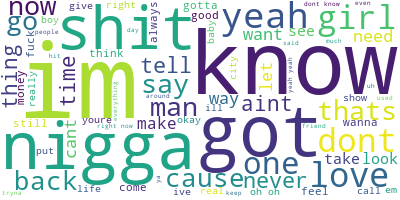

In [9]:
makecloud(drake_df.lyrics)

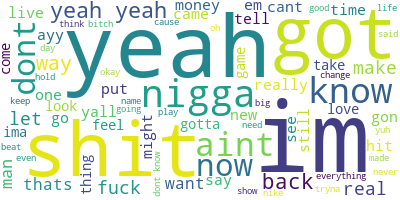

In [10]:
makecloud(quentin_df.lyrics)

In [11]:
# remove obvious identifiers and stem words
stops = set(stopwords.words("english") + ["got", 
                                          "im", "like", "thats", 
                                          "dont", "get", "know", 
                                          "yeah", "shit", "cant", 
                                          "back", "aint"])

In [12]:
drake_tokens = drake_df.lyrics.apply(lambda x:  [w for w in word_tokenize(x) if not w in stops])
quentin_tokens = quentin_df.lyrics.apply(lambda x:  [w for w in word_tokenize(x) if not w in stops])

## Drake Topic Modelling

In [13]:
n_topics=4
vocab_mapping = corpora.Dictionary(drake_tokens)
corpus = [vocab_mapping.doc2bow(tok) for tok in drake_tokens]
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab_mapping,
                                       num_topics=n_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"love" + 0.009*"na" + 0.008*"time" + 0.006*"man" + 0.006*"need" + '
  '0.006*"oh" + 0.006*"wan" + 0.006*"one" + 0.005*"want" + 0.005*"right"'),
 (1,
  '0.010*"love" + 0.007*"cause" + 0.007*"one" + 0.007*"way" + 0.007*"niggas" + '
  '0.007*"never" + 0.007*"say" + 0.006*"right" + 0.006*"girl" + 0.006*"tell"'),
 (2,
  '0.007*"man" + 0.007*"niggas" + 0.007*"never" + 0.007*"cause" + 0.006*"say" '
  '+ 0.006*"tell" + 0.006*"right" + 0.005*"ta" + 0.005*"nigga" + 0.005*"make"'),
 (3,
  '0.008*"go" + 0.008*"girl" + 0.007*"need" + 0.007*"oh" + 0.006*"love" + '
  '0.006*"one" + 0.006*"take" + 0.006*"man" + 0.006*"never" + 0.006*"cause"')]


In [14]:
def tse_viz(lda_model, n_topics=n_topics):
    topic_weights = []
    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list])
  
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Dominant topic
    topic_num = np.argmax(arr, axis=1)

    # PCA into 2 dimensions
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    output_notebook()
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
                  plot_width=800, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
    show(plot)

In [15]:
tse_viz(lda_model)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 278 samples in 0.001s...
[t-SNE] Computed neighbors for 278 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.000745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.020741
[t-SNE] KL divergence after 1000 iterations: 0.056200


Loading BokehJS ...

In [16]:
def top_words(lda_model, tokens):
    data_flat = [w for w_list in tokens for w in w_list]
    counter = Counter(data_flat)
    topics = lda_model.show_topics(formatted=False)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()

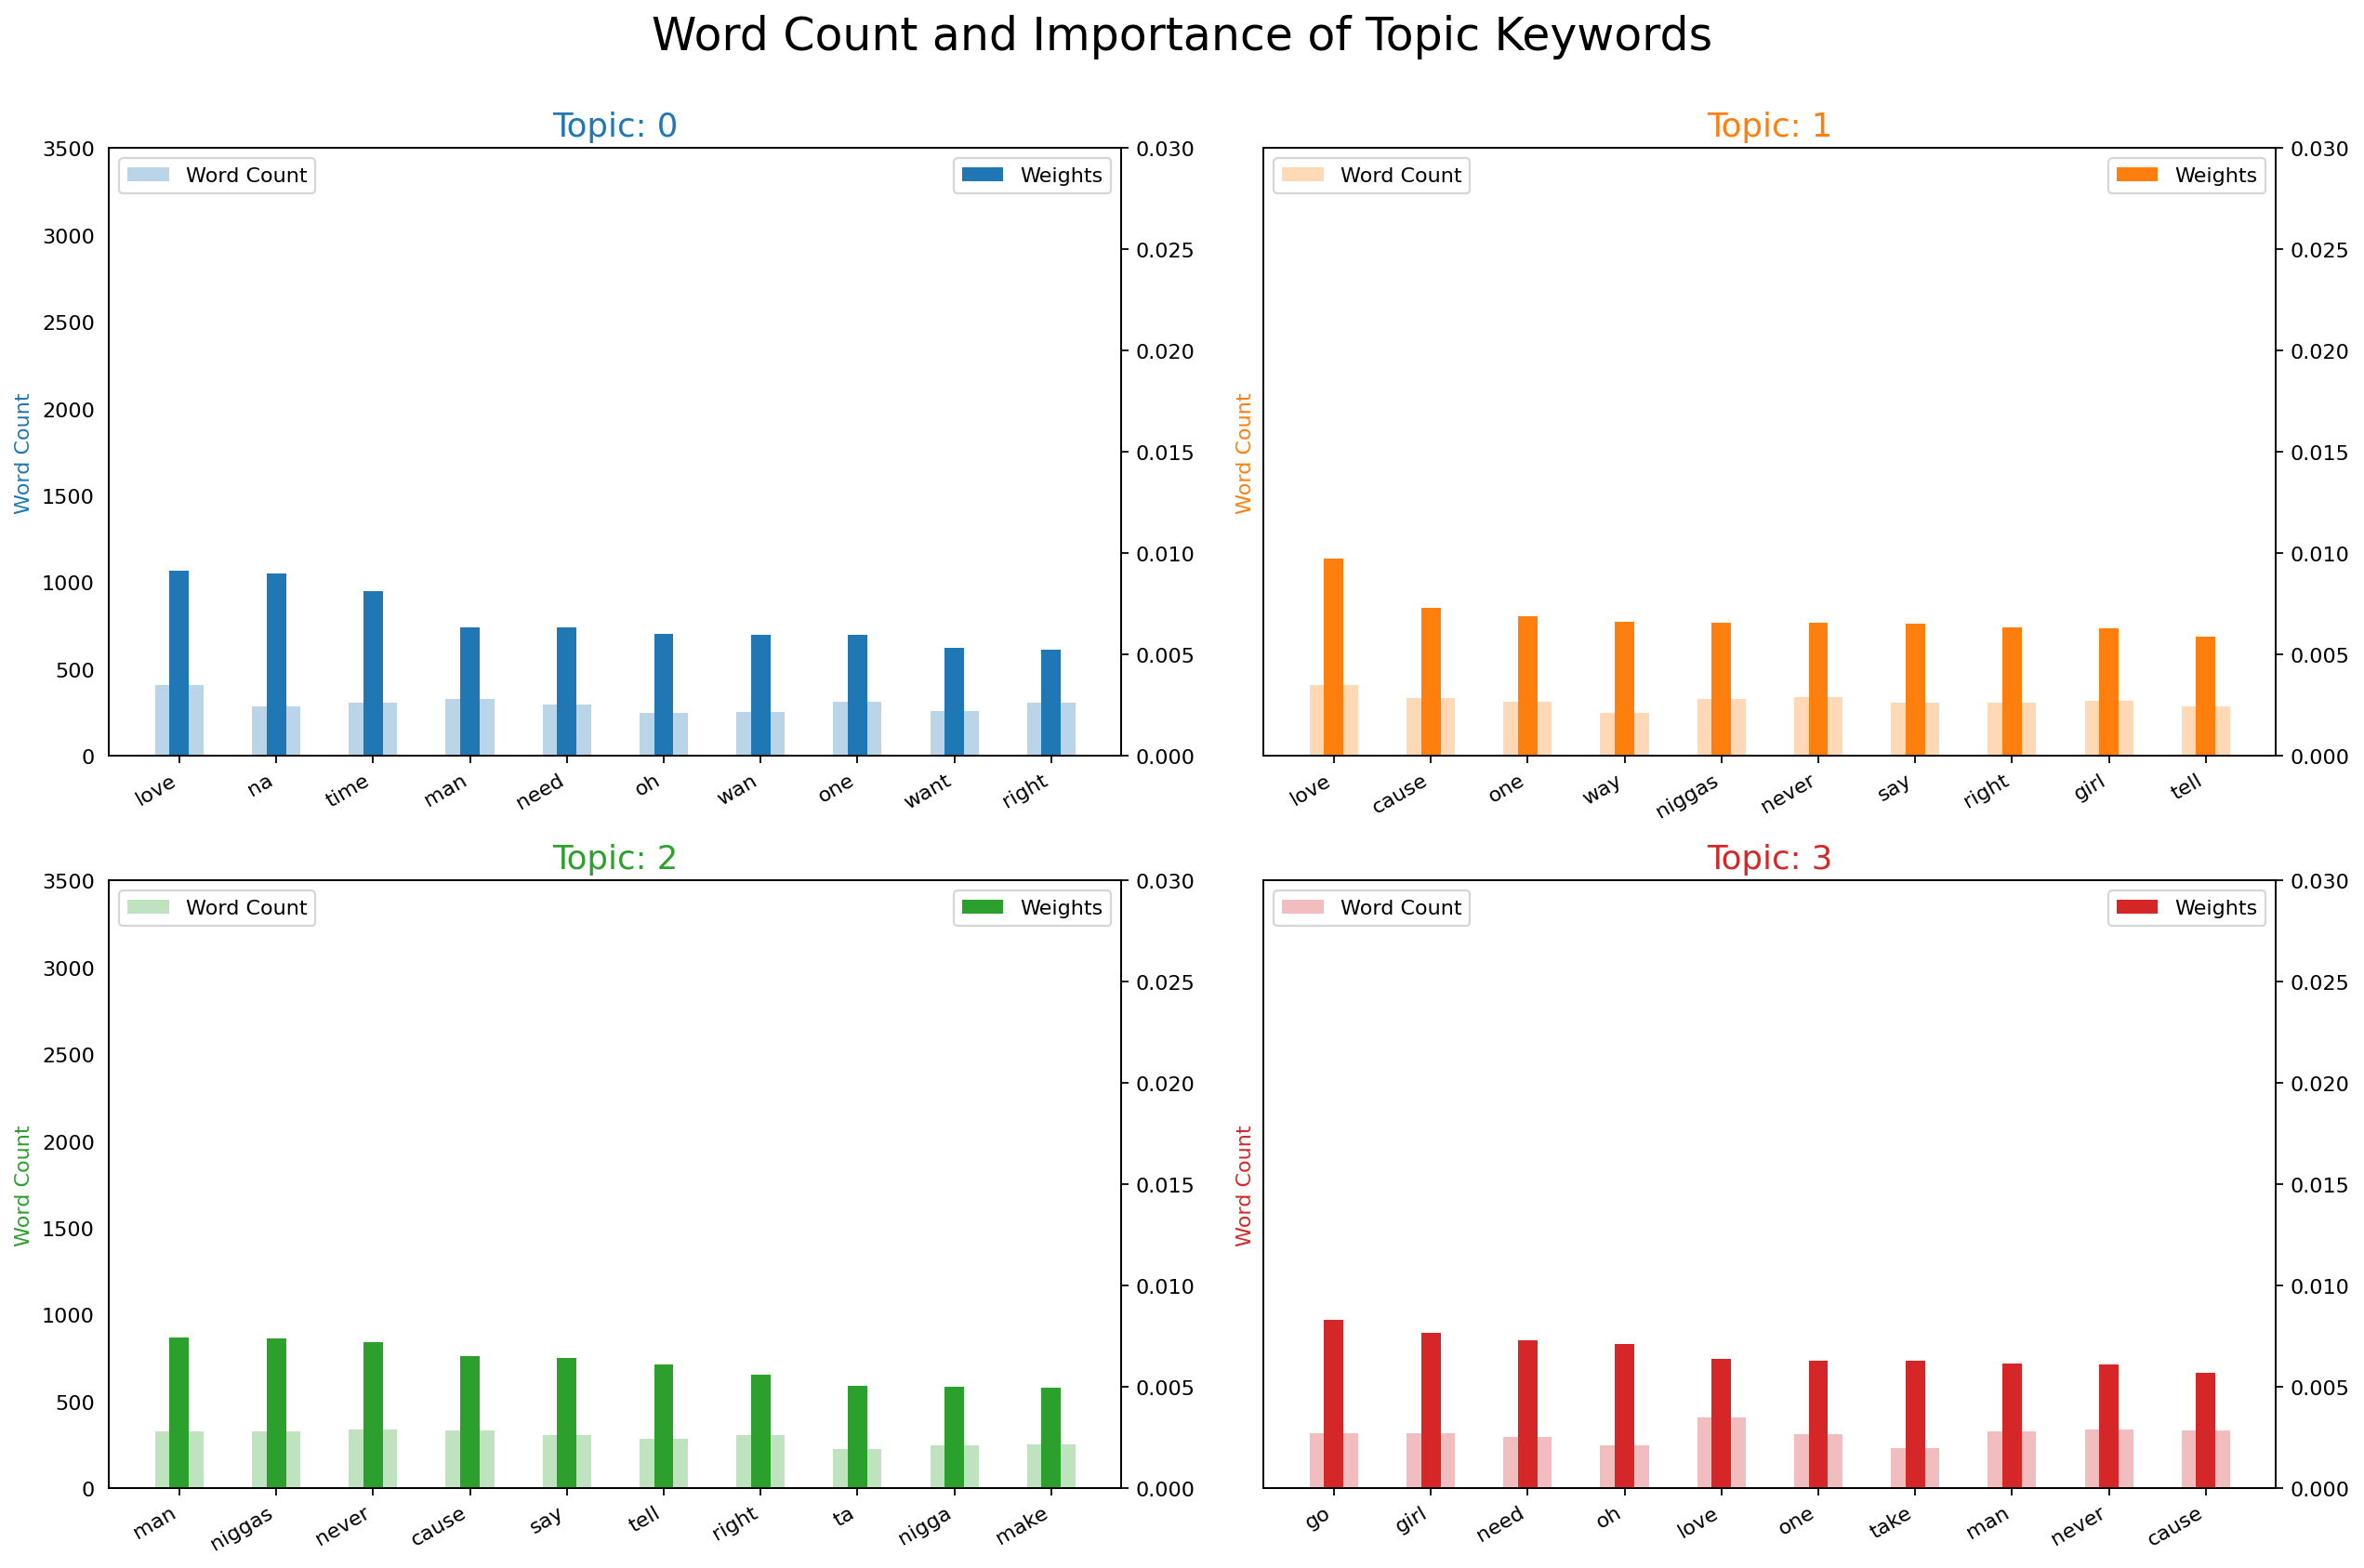

In [17]:
top_words(lda_model, drake_tokens)

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008594  0.006371       1        1  32.598270
2     -0.011627 -0.006675       2        1  26.309740
3      0.008725  0.009507       3        1  23.005952
0      0.011496 -0.009204       4        1  18.086038, topic_info=       Term        Freq       Total Category  logprob  loglift
193      na  239.000000  239.000000  Default  30.0000  30.0000
267      oh  208.000000  208.000000  Default  29.0000  29.0000
263     new  132.000000  132.000000  Default  28.0000  28.0000
209    time  263.000000  263.000000  Default  27.0000  27.0000
2189  brand   38.000000   38.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
145    tell   37.485356  252.116065   Topic4  -5.4265  -0.1959
3        ``   32.099505  183.063341   Topic4  -5.5816  -0.0310
143    take   33.093896  199.892524   Topic4  -5.5511  -0.0884
332    look   30.542612  172.185072   Topic4  -5.6313  -0.0194
204   still   32.367679  211.080556   Topic4  -5.5733  -0.1650

[350 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.386637       ''
0         2  0.243635       ''
0         3  0.243635       ''
0         4  0.121817       ''
3554      1  0.238431        *
...     ...       ...      ...
6582      2  0.556763  wrecked
371       1  0.424411    youre
371       2  0.178699    youre
371       3  0.201037    youre
371       4  0.195453    youre

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

## Quentin Miller Topic Modelling

In [19]:
vocab_mapping = corpora.Dictionary(quentin_tokens)
corpus = [vocab_mapping.doc2bow(tok) for tok in quentin_tokens]
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab_mapping,
                                       num_topics=4)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"ta" + 0.008*"niggas" + 0.008*"real" + 0.006*"make" + 0.006*"go" + '
  '0.006*"man" + 0.006*"em" + 0.006*"really" + 0.006*"way" + 0.005*"nigga"'),
 (1,
  '0.009*"came" + 0.007*"niggas" + 0.007*"make" + 0.007*"man" + 0.006*"ayy" + '
  '0.006*"let" + 0.006*"want" + 0.006*"em" + 0.005*"time" + 0.005*"one"'),
 (2,
  '0.010*"let" + 0.010*"way" + 0.009*"go" + 0.008*"want" + 0.008*"niggas" + '
  '0.006*"ta" + 0.006*"fuck" + 0.006*"bitch" + 0.006*"yall" + 0.005*"man"'),
 (3,
  '0.013*"wait" + 0.007*"real" + 0.007*"hold" + 0.007*"niggas" + 0.006*"ayy" + '
  '0.006*"ta" + 0.005*"nigga" + 0.005*"way" + 0.005*"make" + 0.005*"keep"')]


In [20]:
tse_viz(lda_model)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 0.001165
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.013573
[t-SNE] KL divergence after 1000 iterations: 0.036297


Loading BokehJS ...

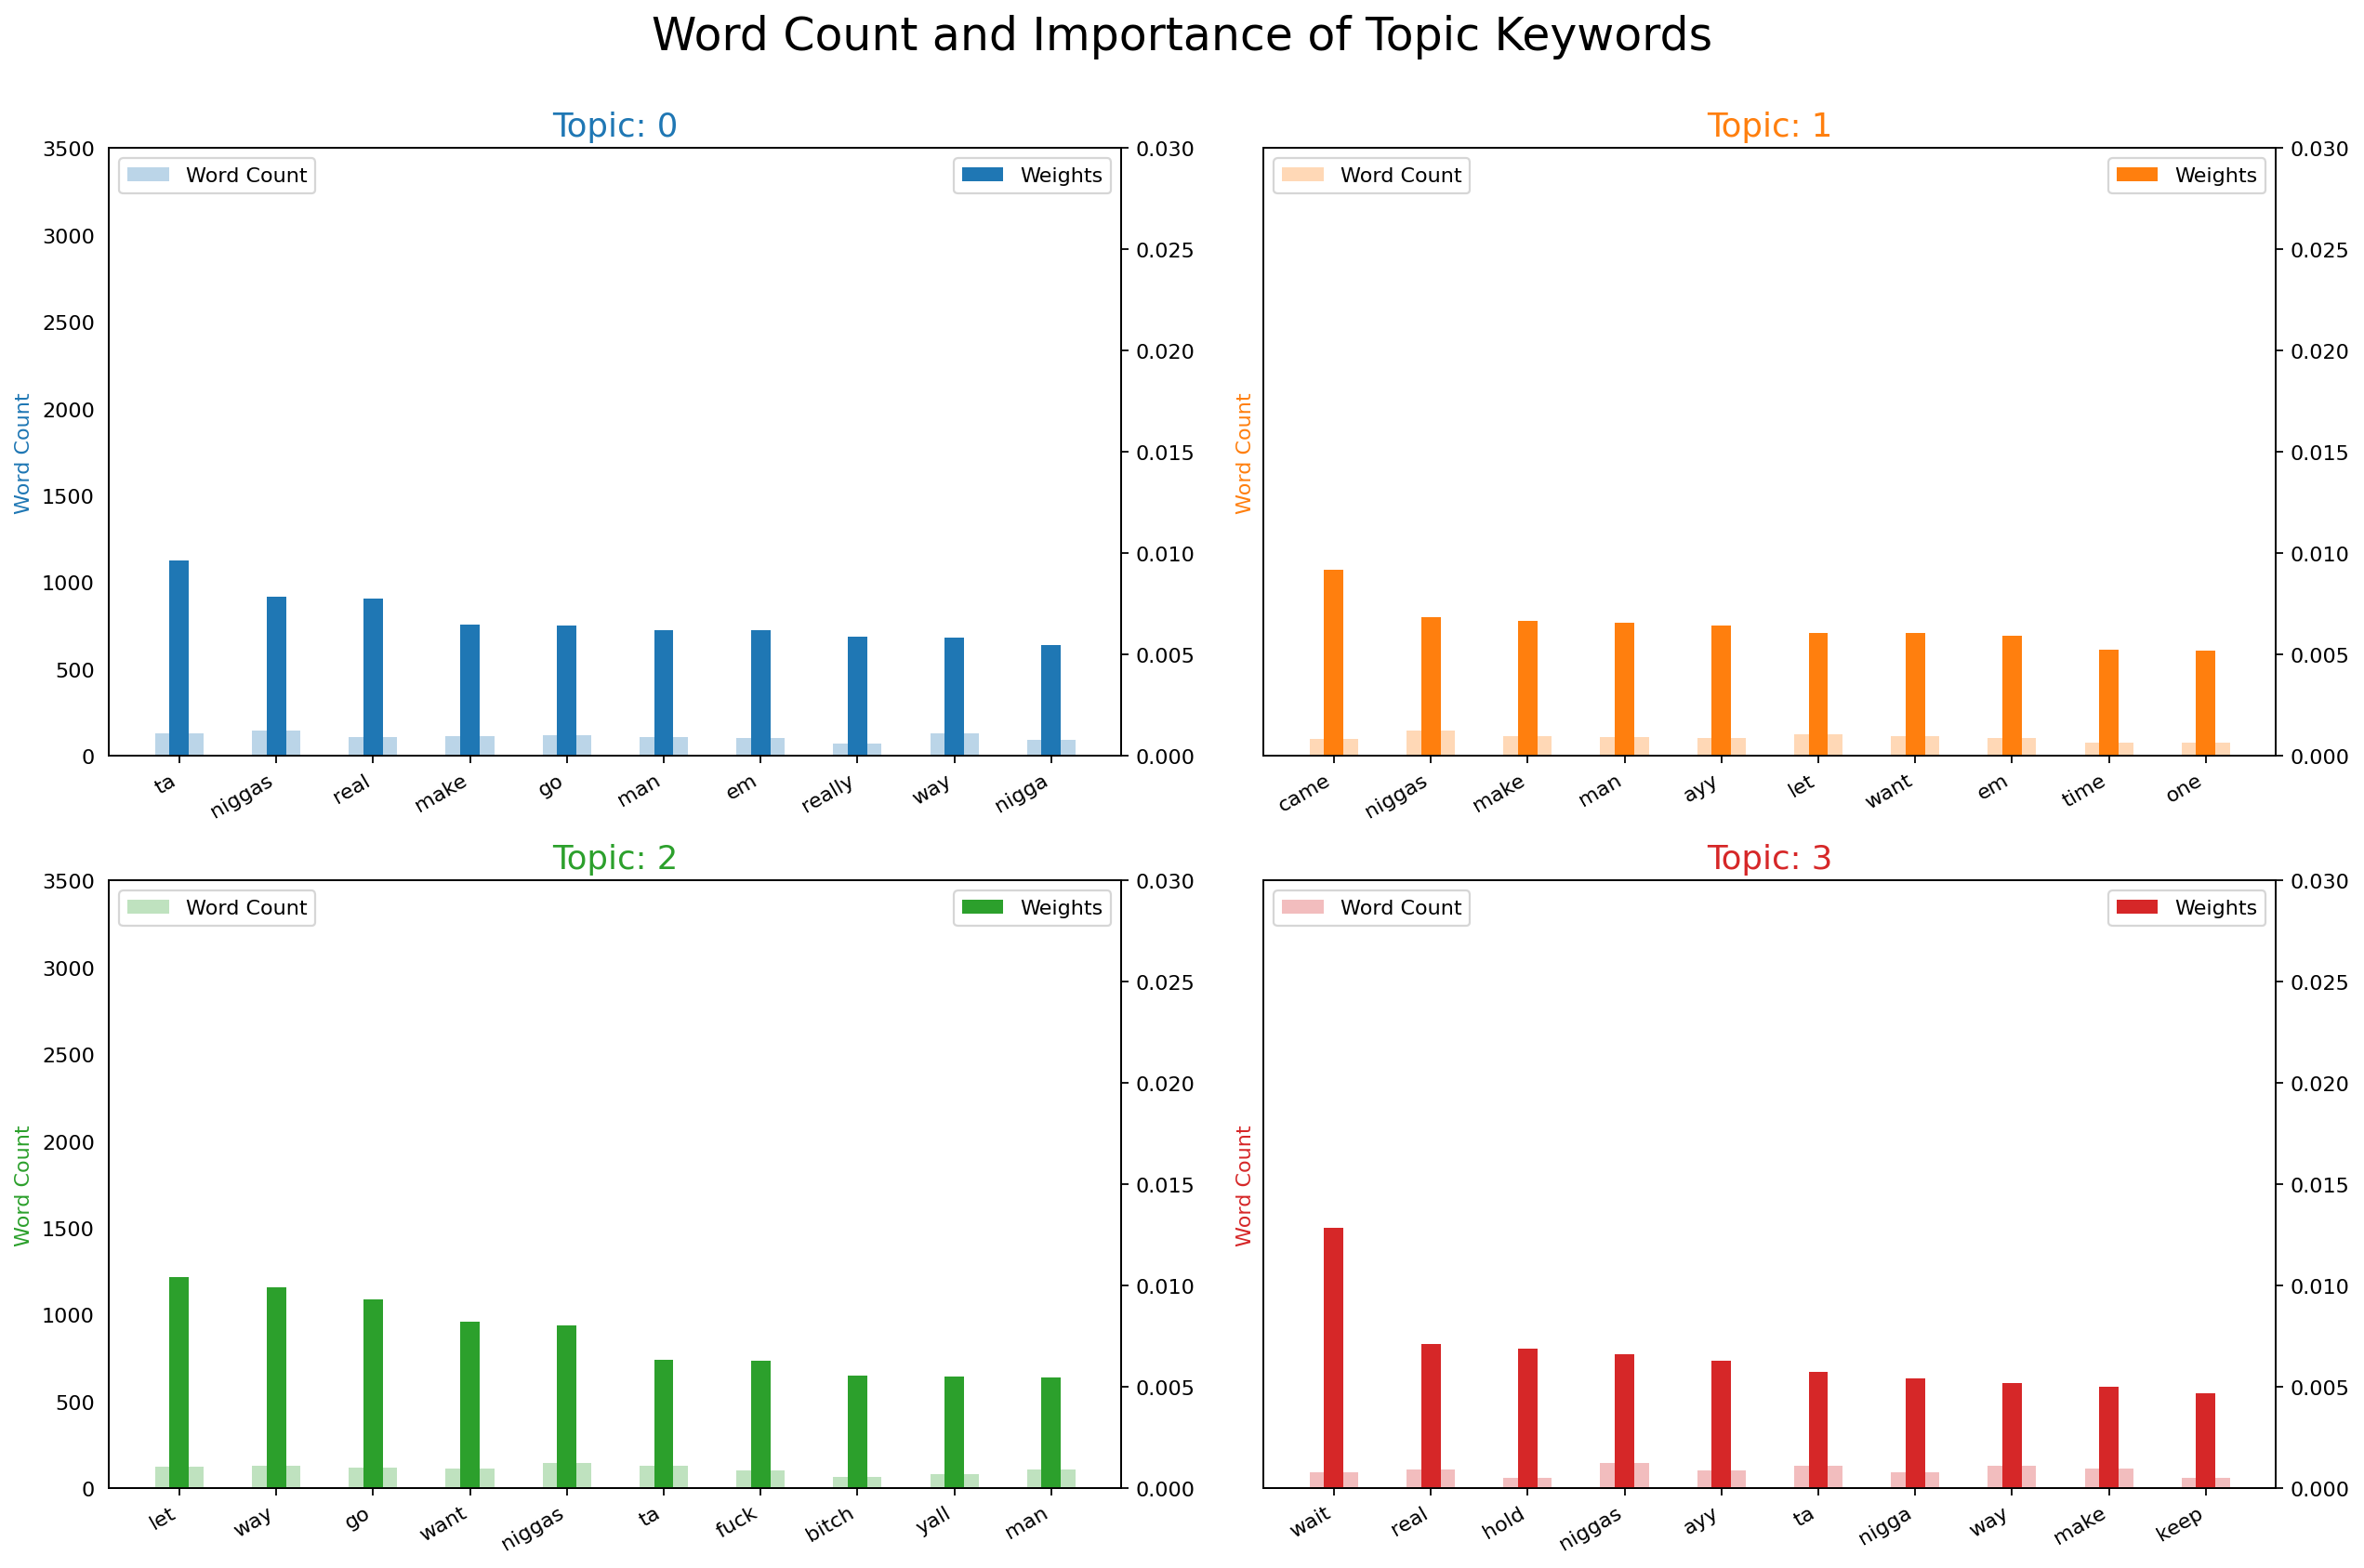

In [21]:
top_words(lda_model, quentin_tokens)

In [22]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003671  0.018075       1        1  33.181174
0      0.000668  0.010005       2        1  29.120025
1      0.023862 -0.016613       3        1  25.923103
3     -0.028201 -0.011467       4        1  11.775698, topic_info=      Term       Freq       Total Category  logprob  loglift
162   wait  63.000000   63.000000  Default  30.0000  30.0000
215   hold  46.000000   46.000000  Default  29.0000  29.0000
1406  deep  18.000000   18.000000  Default  28.0000  28.0000
307   real  87.000000   87.000000  Default  27.0000  27.0000
13    blue  23.000000   23.000000  Default  26.0000  26.0000
...    ...        ...         ...      ...      ...      ...
44    fuck   7.269900   88.354503   Topic4  -5.5808  -0.3585
161   time   6.434220   62.077895   Topic4  -5.7029  -0.1276
68     let   7.397346  106.303440   Topic4  -5.5634  -0.5260
76     man   6.723874   93.977578   Topic4  -5.6588  -0.4983
47      go   6.177871  103.425520   Topic4  -5.7435  -0.6787

[321 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2422      1  0.612493            -
141       3  0.898849           1k
142       3  0.802078       a-town
1954      1  0.360985  abercrombie
1954      2  0.360985  abercrombie
...     ...       ...          ...
321       3  0.172057          yuh
321       4  0.114705          yuh
1980      1  0.358470       zombie
1980      2  0.358470       zombie
1980      4  0.358470       zombie

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

## Quick Analysis of EDA

The word importance graphs, show that our topics are not all that strong. You might have expected the topic model to find distinct topics such as romance, partying, money etc.  but the actual topics are fairly muddled. If you play around with the intertopic distance mapping and adjust the relevance metric, there is definitely some distinction between topics, but as the topic keywords bar chart shows, a lot of these topics are being driven by a few common words. 

One interpretation is that topic modelling is inherently difficult for rap songs. Individual songs are unlikely to use the same topic related word over and over (e.g. car): They instead use pronouns, synonyms, or figurative speech to refer to a single entity. Swear words are incredibly common in rap, yet can be used in very fluid ways. If we really cared about topic modelling, we could do more aggressive stop word removal or even some tf-idf scaling to wash out how often these flex words get used, but, at the end of the day, we probably need a more language aware approach to model rap topics. A huge amount of rap depends on factors such as rhyme scheme, enunciation, pitch, and tone which are very hard to pick up in a bag of words approach. 

The good thing is that topic modelling and our classification task are different tasks. The fact that Quentin Miller uses the word “yeah” frequently doesn’t help build topics within his corpus, but it could differentiate his songs from Drake’s songs. Indeed, when it comes to comparing the two artists, they seem to use similar vocabulary, but Drake appears keener on talking about girls than Quentin Miller. Quentin Miller also is a bit fouler mouthed than Drake based on the word cloud. 

(work in progress: there is definitely more to explore here such as swear word frequency, intra-album topics/word distributions, and looking at the combined corpus of Drake and Quentin Miller songs). 

